## Sequence-to-sequence autoencoder

If you inputs are sequences, rather than vectors or 2D images, then you may want to use as encoder and decoder a type of model that can capture temporal structure, such as a LSTM. To build a LSTM-based autoencoder, first use a LSTM encoder to turn your input sequences into a single vector that contains information about the entire sequence, then repeat this vector n times (where n is the number of timesteps in the output sequence), and run a LSTM decoder to turn this constant sequence into the target sequence.

We won't be demonstrating that one on any specific dataset. We will just put a code example here for future reference for the reader!

In [36]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from keras.models import Model
from keras import backend as K
from keras import regularizers
from keras.utils import plot_model

In [8]:
# Data
# Use the QQQ stock data
qqq = pd.read_csv('QQQ.csv')[-257:]
qqq.shape

(257, 6)

256


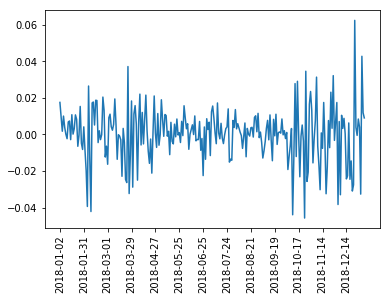

In [11]:
# Normalize the closing price
c = np.array(qqq['Close'])
nqqq = (c - np.roll(c,1)) / np.roll(c,1)
nqqq = nqqq[1:]
ts = np.array(qqq['Index'][1:])
print(len(nqqq))

# Show time series
plt.plot(nqqq)
xidx = list(range(0,len(nqqq),20))
plt.xticks(xidx, ts[xidx], rotation='vertical')
plt.show()


In [37]:
# reshape input into [samples, timesteps, features]
input_dim = len(nqqq)
output_dim = input_dim - 1
seq_in = nqqq.reshape((1, input_dim, 1))
seq_out = seq_in[:, 1:, :]

timesteps = 1
latent_dim = 32

# Model
# define encoder
visible = Input(shape=(input_dim,1))
encoder = LSTM(100, activation='relu')(visible)
# define reconstruct decoder
decoder1 = RepeatVector(input_dim)(encoder)
decoder1 = LSTM(latent_dim, activation='relu', return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(1))(decoder1)
# define predict decoder
decoder2 = RepeatVector(output_dim)(encoder)
decoder2 = LSTM(latent_dim, activation='relu', return_sequences=True)(decoder2)
decoder2 = TimeDistributed(Dense(1))(decoder2)
# tie it together
sequence_autoencoder = Model(inputs=visible, outputs=[decoder1, decoder2])
sequence_autoencoder.compile(optimizer='adam', loss='mse')

sequence_autoencoder.summary()
#plot_model(sequence_autoencoder, show_shapes=True, to_file='composite_lstm_autoencoder.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 256, 1)       0                                            
__________________________________________________________________________________________________
lstm_29 (LSTM)                  (None, 100)          40800       input_15[0][0]                   
__________________________________________________________________________________________________
repeat_vector_15 (RepeatVector) (None, 256, 100)     0           lstm_29[0][0]                    
__________________________________________________________________________________________________
repeat_vector_16 (RepeatVector) (None, 255, 100)     0           lstm_29[0][0]                    
__________________________________________________________________________________________________
lstm_30 (L

In [38]:
print(seq_in.shape)
print(seq_out.shape)
# Training
sequence_autoencoder.fit(seq_in, [seq_in, seq_out], epochs=100)

(1, 256, 1)
(1, 255, 1)
Epoch 1/100
1/1 [==============================] - 19s 19s/step - loss: 4.3320e-04 - time_distributed_1_loss: 2.1619e-04 - time_distributed_2_loss: 2.1701e-04
Epoch 2/100
1/1 [==============================] - 1s 784ms/step - loss: 4.3642e-04 - time_distributed_1_loss: 2.1791e-04 - time_distributed_2_loss: 2.1851e-04
Epoch 3/100
1/1 [==============================] - 1s 769ms/step - loss: 4.3252e-04 - time_distributed_1_loss: 2.1615e-04 - time_distributed_2_loss: 2.1637e-04
Epoch 4/100
1/1 [==============================] - 1s 772ms/step - loss: 4.3240e-04 - time_distributed_1_loss: 2.1638e-04 - time_distributed_2_loss: 2.1601e-04
Epoch 5/100
1/1 [==============================] - 1s 786ms/step - loss: 4.3307e-04 - time_distributed_1_loss: 2.1624e-04 - time_distributed_2_loss: 2.1683e-04
Epoch 6/100
1/1 [==============================] - 1s 787ms/step - loss: 4.3251e-04 - time_distributed_1_loss: 2.1630e-04 - time_distributed_2_loss: 2.1621e-04
Epoch 7/100
1/1 [

Epoch 52/100
1/1 [==============================] - 1s 778ms/step - loss: 4.3064e-04 - time_distributed_1_loss: 2.1525e-04 - time_distributed_2_loss: 2.1539e-04
Epoch 53/100
1/1 [==============================] - 1s 773ms/step - loss: 4.3059e-04 - time_distributed_1_loss: 2.1523e-04 - time_distributed_2_loss: 2.1537e-04
Epoch 54/100
1/1 [==============================] - 1s 773ms/step - loss: 4.3057e-04 - time_distributed_1_loss: 2.1520e-04 - time_distributed_2_loss: 2.1536e-04
Epoch 55/100
1/1 [==============================] - 1s 776ms/step - loss: 4.3053e-04 - time_distributed_1_loss: 2.1518e-04 - time_distributed_2_loss: 2.1535e-04
Epoch 56/100
1/1 [==============================] - 1s 805ms/step - loss: 4.3049e-04 - time_distributed_1_loss: 2.1516e-04 - time_distributed_2_loss: 2.1533e-04
Epoch 57/100
1/1 [==============================] - 1s 786ms/step - loss: 4.3047e-04 - time_distributed_1_loss: 2.1514e-04 - time_distributed_2_loss: 2.1533e-04
Epoch 58/100
1/1 [================

In [44]:
# encode and decode some digits
yhat = sequence_autoencoder.predict(seq_in)
y_decoded = yhat[0].reshape(input_dim)
y_pred = yhat[1].reshape(input_dim-1)
print(y_pred.shape)

(255,)


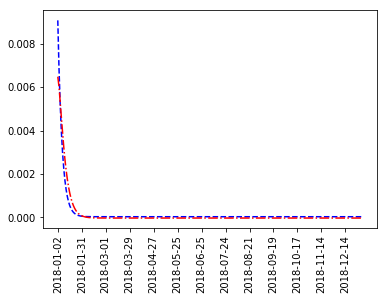

In [49]:
# Show time series
#plt.plot(nqqq[1:], 'k-', alpha=0.3)
plt.plot(y_decoded[1:], 'b--')
plt.plot(y_pred, 'r-.')
xidx = list(range(0,len(nqqq)-1,20))
plt.xticks(xidx, ts[xidx], rotation='vertical')
plt.show()